For importing delta you need to make sure that you have selected the right kernel

If the below cell doesn't work, you might need to install the kernel first.

For doing so, follow these steps:

1. conda install ipykernel
2. python -m ipykernel install --user --name=bills --display-name "Python (bills)"

Now you should be able to select the Python (bills) kernell which will be pointing to the conda environment
containing the libraries for this project

In [5]:
import os
import re
from pathlib import Path
from pyspark.sql import SparkSession
from operator import itemgetter

from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType

from pyspark.sql.functions import lit, input_file_name, split, col
import uuid
from datetime import datetime
from delta import *

In [1]:
!python --version

Python 3.9.16


In [2]:
!which python

/opt/homebrew/anaconda3/envs/bills/bin/python


In [3]:
import sys

# Print the Python version
print(sys.version)

# Print only the major, minor, and micro versions
print(sys.version_info)

3.9.16 (main, Mar  8 2023, 04:29:24) 
[Clang 14.0.6 ]
sys.version_info(major=3, minor=9, micro=16, releaselevel='final', serial=0)


The above uses method configure_spark_with_delta_pip from the delta library which installs the necessaries
maven dependencies for the underlying pyspark process. The implementation of the function can be found here:

https://github.com/delta-io/delta/blob/da162a097a25524fc97334f47a180257cb487789/python/delta/pip_utils.py#L23

In [6]:
builder = SparkSession \
     .builder \
     .master("local[2]") \
     .config('spark.cores.max', '3') \
     .config('spark.executor.memory', '2g') \
     .config('spark.executor.cores', '2') \
     .config('spark.sql.catalogImplementation', 'hive') \
     .config('spark.driver.memory', '1g') \
     .config('spark.sql.extensions', 'io.delta.sql.DeltaSparkSessionExtension') \
     .config('spark.sql.catalog.spark_catalog', 'org.apache.spark.sql.delta.catalog.DeltaCatalog') \
     .enableHiveSupport()

spark = configure_spark_with_delta_pip(builder).getOrCreate()

:: loading settings :: url = jar:file:/opt/homebrew/anaconda3/envs/bills/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/andreslaurito/.ivy2/cache
The jars for the packages stored in: /Users/andreslaurito/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c52d0af5-b0fe-4482-9bcc-b8f53e7fcfa6;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.2.0 in central
	found io.delta#delta-storage;3.2.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 91ms :: artifacts dl 4ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.2.0 from central in [default]
	io.delta#delta-storage;3.2.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default    

In [7]:
now = datetime.now()

spark \
	.read \
    .text("/Users/andreslaurito/repos/household-bills/household-bills/tickets", wholetext=True)\
    .withColumn("__LoadID", lit(str(uuid.uuid4()))) \
	.withColumn("__DCR", lit(str(now)).cast("timestamp")) \
    .withColumn("_file_name", input_file_name()) \
    .createOrReplaceTempView("raw_tickets")


In [8]:
# Note: Dia matches a lot of things bc of its meaning :)
supermarkets = ['mercadona', 'aldi', 'grupo dia',
                'primark', 'prenatal', 'zeeman',
                'condis', 'carrefour', 'consum',
                'miscota', 'farmacia', 'veritas',
                'lidl']


In [9]:
all_tickets = spark.sql("select * from raw_tickets")

all_tickets.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
query = "SELECT * FROM raw_tickets where not ("
for supermarket in supermarkets:
    query += f"value ilike '%{supermarket}%' or "

query = query[:-4]
query += ')'

tickets_not_belonging_to_supermarkets = spark.sql(query)

In [12]:
tickets_not_belonging_to_supermarkets.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
df_per_supermarkets = {
    supermarket: spark.sql(f"SELECT * FROM raw_tickets where value ilike '%{supermarket}%'")
    for supermarket in supermarkets
}

def total_spent(df):
    imports_per_ticket = []
    for row in df.select('splitted').collect():
        for word in row.splitted:
            if 'Import' in word:
                wordmatch = re.findall("\d+\,\d+", word)
                if wordmatch:
                    imports_per_ticket.append(float(wordmatch[0].replace(',', '.')))
        #         re.
        # ticket_import = [[0] for word in row.splitted if 'Import' in word]
        # imports_per_ticket.extend([float(importnum.replace(',', '.')) for importnum in ticket_import])
    return sum(imports_per_ticket)


info_per_supermarket = {
    supermarket: {
        'df': df,
        'count': df.count(),
        'df_splitted': df.withColumn('splitted', split(col('value'), '\r\n')),
        'total_spent': total_spent(df.withColumn('splitted', split(col('value'), '\r\n')))
    } for supermarket, df in df_per_supermarkets.items() }

In [14]:
info_per_supermarket

{'mercadona': {'df': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string],
  'count': 26,
  'df_splitted': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string, splitted: array<string>],
  'total_spent': 1643.1600000000003},
 'aldi': {'df': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string],
  'count': 51,
  'df_splitted': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string, splitted: array<string>],
  'total_spent': 0},
 'grupo dia': {'df': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string],
  'count': 3,
  'df_splitted': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string, splitted: array<string>],
  'total_spent': 0},
 'primark': {'df': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_name: string],
  'count': 2,
  'df_splitted': DataFrame[value: string, __LoadID: string, __DCR: timestamp, _file_n

In [15]:
info_per_supermarket['mercadona']['df'].show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
supermarkets_most_tickets = sorted([(supermarket, value['count']) for supermarket, value in info_per_supermarket.items()],
                                   key=itemgetter(1), reverse=True)

supermarkets_most_spent = sorted([(supermarket, value['total_spent']) for supermarket, value in info_per_supermarket.items()],
                                  key=itemgetter(1), reverse=True)



In [17]:
supermarkets_most_tickets

[('aldi', 51),
 ('mercadona', 26),
 ('carrefour', 19),
 ('condis', 10),
 ('consum', 8),
 ('grupo dia', 3),
 ('prenatal', 3),
 ('miscota', 3),
 ('primark', 2),
 ('zeeman', 2),
 ('farmacia', 2),
 ('lidl', 2),
 ('veritas', 1)]

In [18]:
supermarkets_most_spent

[('mercadona', 1643.1600000000003),
 ('carrefour', 45.7),
 ('primark', 42.0),
 ('consum', 23.21),
 ('miscota', 8.23),
 ('aldi', 0),
 ('grupo dia', 0),
 ('prenatal', 0),
 ('zeeman', 0),
 ('condis', 0),
 ('farmacia', 0),
 ('veritas', 0),
 ('lidl', 0)]

In [111]:
df_mercadona.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [128]:
import re
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, DateType

# Sample input data
# Define the UDF function to extract ticket data
def extract_ticket_data(text):
    rows = []
    ticket_data = text.split("\r\n")
    recipe_date = ""
    for i in range(len(ticket_data)):
        product_quantity = ""
        product_name = ""
        unit_price = ""
        total_price = ""
        
        # Match pattern for product and name
        date_pattern = re.compile(r"\d+\/\d+\/\d+")
        regex_matched = date_pattern.search(ticket_data[i])
        if regex_matched:
            # Should match only once per recipe
            recipe_date = regex_matched[0]
            
        if re.match(r"\d \w+", ticket_data[i]):
            regex_match = re.match(r"(\d+)( )(\w+(\s\w+)*)", ticket_data[i])
            if regex_match:
                product_quantity = regex_match[1]
                product_name = regex_match[3]

                # Find unit and total price in subsequent lines
                unit_price_idx = i + 1
                total_price_idx = i + 2

                unit_price = ticket_data[unit_price_idx] if unit_price_idx < len(ticket_data) and re.match(r"\d+,\d+", ticket_data[unit_price_idx]) else ""
                total_price = ticket_data[total_price_idx] if total_price_idx < len(ticket_data) and re.match(r"\d+,\d+", ticket_data[total_price_idx]) else ""
                    
                # Append extracted data
                rows.append((product_quantity, product_name, unit_price, total_price, recipe_date))

    return rows

# Define UDF with return type as ArrayType of StructType (list of rows)
schema = StructType([
    StructField("product_quantity", StringType(), True),
    StructField("product_name", StringType(), True),
    StructField("unit_price", StringType(), True),
    StructField("total_price", StringType(), True),
    StructField("recipe_date", StringType(), True)
])

# Initialize an empty DataFrame with the defined schema
mercadona_products_df = spark.createDataFrame([], schema)

# Iterate through each row in the original DataFrame and apply the UDF
for row in df_mercadona.collect():
    extracted_data = extract_ticket_data(row['value'])
    print(extracted_data)
    if extracted_data:
        # Convert the extracted data to a DataFrame
        temp_df = spark.createDataFrame(extracted_data, schema)
        # Append the new rows to the new DataFrame
        mercadona_products_df = mercadona_products_df.union(temp_df)


mercadona_products_df.write.format("delta").mode("overwrite").saveAsTable("mercadona_products")

[('2', 'FORMATGE RATLLAT POL', '1,25', '2,50', '15/12/2023'), ('3', 'FORMATGE RATLLAT PIZ', '1,54', '4,62', '15/12/2023'), ('1', 'MOS SENSE GLUTEN', '1,85', '', '15/12/2023'), ('1', 'FORMATGE TENDRE', '3,32', '', '15/12/2023'), ('1', 'FILET ROMANÍ', '5,35', '', '15/12/2023'), ('1', 'PICADA ALL JULIVERT', '1,45', '', '15/12/2023'), ('1', 'GRIEGO STRACCIAT', '1,90', '', '15/12/2023'), ('1', 'LLET SEMI P6', '5,22', '', '15/12/2023'), ('1', 'FILET DE PIT', '5,23', '', '15/12/2023'), ('1', 'ESPAGUETIS S', '2,00', '', '15/12/2023'), ('2', 'PA DE PESSIC XOC SG 3', '', '3,78', '15/12/2023'), ('1', 'BURGER BOVI PORC', '3,78', '', '15/12/2023'), ('1', 'NOU CLOSCA NATURAL', '2,90', '', '15/12/2023'), ('1', 'COCTEL NATURAL', '', '2,50', '15/12/2023'), ('1', 'PA M BLANC S', '2,50', '2,95', '15/12/2023'), ('1', 'COQUETA LLEGUM 44', '1,75', '', '15/12/2023'), ('1', 'CORN FLAKES S', '2,59', '', '15/12/2023'), ('2', 'CEREAL FARCIT S', '2,25', '2,25', '15/12/2023'), ('2', 'NATILLA XOCOLATA X 4', '2,00',

24/12/27 17:45:19 ERROR HiveAlterHandler: Failed to alter table default.mercadona_products
24/12/27 17:45:19 WARN HiveExternalCatalog: Could not alter schema of table `default`.`mercadona_products` in a Hive compatible way. Updating Hive metastore in Spark SQL specific format.
java.lang.reflect.InvocationTargetException
	at jdk.internal.reflect.GeneratedMethodAccessor262.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at org.apache.spark.sql.hive.client.Shim_v2_1.alterTable(HiveShim.scala:1611)
	at org.apache.spark.sql.hive.client.HiveClientImpl.$anonfun$alterTableDataSchema$1(HiveClientImpl.scala:633)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.sql.hive.client.HiveClientImpl.$anonfun$withHiveState$1(HiveClientImpl.scala:303)
	at org.apache.spark.sql.hive.client.HiveClientImpl.liftedTree1$

In [123]:
spark.sql("DROP TABLE mercadona_products")

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `spark_catalog`.`default`.`mercadona_products` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.

In [129]:
spark.sql("SELECT * FROM mercadona_products").show(300)

+----------------+--------------------+------------------+------------------+-----------+
|product_quantity|        product_name|        unit_price|       total_price|recipe_date|
+----------------+--------------------+------------------+------------------+-----------+
|               2|FORMATGE RATLLAT POL|              1,25|              2,50| 15/12/2023|
|               3|FORMATGE RATLLAT PIZ|              1,54|              4,62| 15/12/2023|
|               1|    MOS SENSE GLUTEN|              1,85|                  | 15/12/2023|
|               1|     FORMATGE TENDRE|              3,32|                  | 15/12/2023|
|               1|        FILET ROMANÍ|              5,35|                  | 15/12/2023|
|               1| PICADA ALL JULIVERT|              1,45|                  | 15/12/2023|
|               1|    GRIEGO STRACCIAT|              1,90|                  | 15/12/2023|
|               1|        LLET SEMI P6|              5,22|                  | 15/12/2023|
|         

In [149]:
from pyspark.sql import functions as F

bananas_df = spark.sql("SELECT * FROM mercadona_products where product_name ilike '%banana%'")

bananas_with_dates = bananas_df.withColumn("recipe_date_asdate", F.to_date("recipe_date", "dd/MM/yyyy")).drop("recipe_date")

bananas_with_dates.sort("recipe_date_asdate").show()

+----------------+------------+--------------------+-----------+------------------+
|product_quantity|product_name|          unit_price|total_price|recipe_date_asdate|
+----------------+------------+--------------------+-----------+------------------+
|               1|      BANANA|            1,880 kg|  1,08 €/kg|        2023-07-29|
|               1|      BANANA|            1,356 kg|  1,08 €/kg|        2023-08-05|
|               1|      BANANA|  2,080 kg 1,05 €/kg|       2,18|        2023-08-30|
|               1|      BANANA|            1,662 kg|  1,45 €/kg|        2023-09-20|
|               1|      BANANA|            2,022 kg|  1,45 €/kg|        2023-10-02|
|               1|      BANANA|            2,022 kg|  1,45 €/kg|        2023-10-02|
|               1|      BANANA|                2,25|   1,352 kg|        2023-10-20|
|               1|      BANANA|  1,224 kg 1,09 €/kg|       1,33|        2023-10-27|
|               1|      BANANA|  1,290 kg 1.05 €/kg|           |        2023

+----------------+------------+--------------------+-----------+------------------+---------------------+-------------------+---------------+
|product_quantity|product_name|          unit_price|total_price|recipe_date_asdate|recipe_date_timestamp|total_price_cleaned|total_price_int|
+----------------+------------+--------------------+-----------+------------------+---------------------+-------------------+---------------+
|               1|      BANANA|            2,022 kg|  1,45 €/kg|        2023-10-02|           1696197600|               1,45|           1.45|
|               1|      BANANA|            1,880 kg|  1,08 €/kg|        2023-07-29|           1690581600|               1,08|           1.08|
|               1|      BANANA|            2,022 kg|  1,45 €/kg|        2023-10-02|           1696197600|               1,45|           1.45|
|               1|      BANANA|                2,25|   1,352 kg|        2023-10-20|           1697752800|              1,352|          1.352|
|     

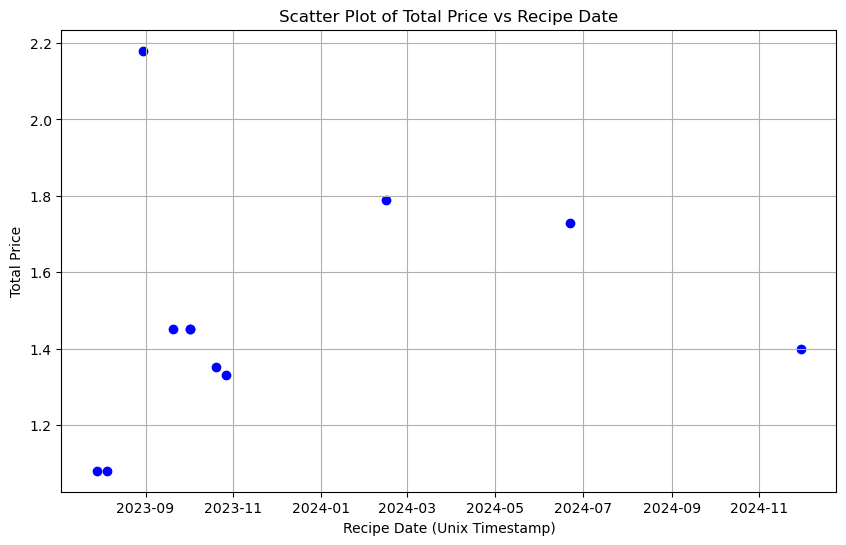

In [162]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

bananas_with_dates_cleaned = bananas_with_dates.withColumn(
    "total_price_cleaned", 
    F.regexp_replace("total_price", r"[^\d,\.]", "")  # Remove all non-numeric characters except ',' and '.'
)

# Convert the cleaned 'total_price' column to a numeric type
bananas_with_dates_cleaned = bananas_with_dates_cleaned.withColumn(
    "total_price_int", 
    F.when(
        F.trim(F.col("total_price_cleaned")) != "", 
        F.regexp_replace(F.col("total_price_cleaned"), ",", ".").cast("double")
    ).otherwise(None)
)

# Assuming 'bananas_with_dates' is your PySpark DataFrame
# Convert 'recipe_date_asdate' to timestamp (numeric format)
bananas_with_dates = bananas_with_dates_cleaned.withColumn("recipe_date_timestamp", F.unix_timestamp("recipe_date_asdate", "yyyy-MM-dd"))

bananas_with_dates.show()

# Convert to Pandas DataFrame for easy plotting
pandas_df = bananas_with_dates.select("recipe_date_asdate", "total_price_int").toPandas()

# Clean the 'total_price' column to ensure it's a numeric type
pandas_df["total_price"] = pd.to_numeric(pandas_df["total_price_int"], errors='coerce')  # Convert invalid values to NaN

print(pandas_df)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["recipe_date_asdate"], pandas_df["total_price_int"], color='blue', label='Total Price')
plt.title("Scatter Plot of Total Price vs Recipe Date")
plt.xlabel("Recipe Date (Unix Timestamp)")
plt.ylabel("Total Price")
plt.grid(True)
plt.show()

In [102]:
spark.sql("SELECT * FROM mercadona_products where product_name ilike '%salmo%'").show(300)

+----------------+--------------+----------+-----------+
|product_quantity|  product_name|unit_price|total_price|
+----------------+--------------+----------+-----------+
|               1|   FILET SALMO|      4,16|           |
|               1|FILET DE SALMO|     11,47|           |
+----------------+--------------+----------+-----------+



In [107]:
spark.sql("SELECT * FROM mercadona_products where product_name ilike '%ANARCARDS%'").show(300)

+----------------+-----------------+----------+-----------+
|product_quantity|     product_name|unit_price|total_price|
+----------------+-----------------+----------+-----------+
|               1|ANARCARDS NATURAL|      2,30|           |
|               1|ANARCARDS NATURAL|      2,30|           |
|               1|ANARCARDS NATURAL|      2,30|           |
|               1|ANARCARDS NATURAL|      2,30|           |
|               1|ANARCARDS NATURAL|      2,30|           |
|               2|ANARCARDS NATURAL|      3,00|           |
+----------------+-----------------+----------+-----------+

